# Modeling Mouse learning across different age group using bayesian model and hierarchical bayesian model #

In [1]:
#Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy import stats
import numpy as np
import seaborn as sns
import pymc as pm

In [ ]:
#To Install pymc package, skip this.
pip install pymc --proxy http://proxy.ucsd.edu:3128

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("/Users/benchen/NeuralHub/DRKM_Mouse_Jun25/young_cohort_execution_df.csv")
print(df.columns)

# Assuming data_tmp is your dataframe with trial-level data
# Create an empty list to store each session's summary data
summary_data = []

data_df = df[df['Condition'] == '80-20']  # Filter for retrain == 0

Index(['Mouse', 'Age_Groups', 'Trial', 'blockTrial', '0_ITI',
       '0_trialDuration', 'Decision', '1_Port', '1_Reward', '1_ITI',
       '1_trialDuration', '2_Port', '2_Reward', '2_ITI', '2_trialDuration',
       '3_Port', '3_Reward', '3_ITI', '3_trialDuration', 'highPort', 'Reward',
       'Mouse ID', 'Session ID', 'Condition', 'Switch', 'laser_stim', 'Target',
       'Block ID', 'blockLength', 'session_pos', 'retrain', 'DOB', 'Sex',
       'Start_Age', 'Cohort_Name', 'Trial_based', 'Fibers',
       'Dreadds_During_Training', 'Viral_expression', 'Genotype',
       'Date_of_Surgery', 'Date', 'Current_age', 'Session_Number',
       'block_pos_rev'],
      dtype='object')


In [3]:
#New column with mouse and session number specified
data_df['Session_ID'] = data_df.Mouse.astype(str) + "_Session" + data_df['Session_Number'].astype(str)

print(data_df.Session_ID.head())

#Identifying unique Mouse and Session combination in the data_df column
unique_mouse_sessions = data_df['Session_ID'].unique()
print(unique_mouse_sessions)
print(len(unique_mouse_sessions))

0    YC1N_Session5
1    YC1N_Session5
2    YC1N_Session5
3    YC1N_Session5
4    YC1N_Session5
Name: Session_ID, dtype: object
['YC1N_Session5' 'YC1N_Session6' 'YC1N_Session7' 'YC1N_Session8'
 'YC1N_Session9' 'YC1N_Session10' 'YC1L_Session5' 'YC1L_Session6'
 'YC1L_Session7' 'YC1L_Session8' 'YC1L_Session9' 'YC1R_Session5'
 'YC1R_Session6' 'YC1R_Session7' 'YC1R_Session8' 'YC1R_Session9'
 'YC1R_Session10' 'YC1B_Session5' 'YC1B_Session6' 'YC1B_Session7'
 'YC1B_Session8' 'YC1B_Session9' 'YC1B_Session10' 'YC2N_Session5'
 'YC2N_Session6' 'YC2N_Session7' 'YC2N_Session8' 'YC2N_Session9'
 'YC2N_Session10' 'YC2L_Session5' 'YC2L_Session6' 'YC2L_Session7'
 'YC2L_Session8' 'YC2L_Session9' 'YC2L_Session10' 'YC2R_Session5'
 'YC2R_Session6' 'YC2R_Session7' 'YC2R_Session8' 'YC2R_Session9'
 'YC2R_Session10' 'YC2B_Session5' 'YC2B_Session6' 'YC2B_Session7'
 'YC2B_Session8' 'YC2B_Session9' 'YC2B_Session10' 'YC3N_Session5'
 'YC3N_Session6' 'YC3N_Session7' 'YC3N_Session8' 'YC3N_Session9'
 'YC3N_Session10' 'YC

In [20]:
data_df

,Mouse,Age_Groups,Trial,blockTrial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,...,Genotype,Date_of_Surgery,Date,Current_age,Session_Number,block_pos_rev,Session_ID,lose_switch,win-stay,Prev_Reward
0,YC1N,0,4,4,1.709,0.343,0,0,1,2.532,...,WT,NaN,2002/11/25,49,5,-10,YC1N_Session5,0,0,0
1,YC1N,0,5,5,1.554,0.647,0,0,0,1.709,...,WT,NaN,2002/11/25,49,5,-9,YC1N_Session5,0,0,0
2,YC1N,0,6,6,5.535,0.540,1,0,0,1.554,...,WT,NaN,2002/11/25,49,5,-8,YC1N_Session5,0,0,0
3,YC1N,0,7,7,5.602,0.474,0,1,1,5.535,...,WT,NaN,2002/11/25,49,5,-7,YC1N_Session5,0,0,1
4,YC1N,0,8,8,1.847,0.263,0,0,1,5.602,...,WT,NaN,2002/11/25,49,5,-6,YC1N_Session5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90639,YC8B,0,524,6,2.145,0.263,1,1,1,1.594,...,WT,NaN,2/13/25,51,10,-5,YC8B_Session10,0,0,1
90640,YC8B,0,525,7,1.690,0.313,1,1,1,2.145,...,WT,NaN,2/13/25,51,10,-4,YC8B_Session10,0,0,1
90641,YC8B,0,526,8,1.579,0.323,1,1,1,1.690,...,WT,NaN,2/13/25,51,10,-3,YC8B_Session10,0,0,1
90642,YC8B,0,527,9,1.659,0.352,1,1,1,1.579,...,WT,NaN,2/13/25,51,10,-2,YC8B_Session10,0,0,1


## Summary Dataframe ##

In [4]:
#Initialize summary_data list
summary_data = []


#calculate metrics for each unique mouse session
for session_id in unique_mouse_sessions:

    #Slicing the dataframe, so that the portion for the specific mouse/session is obtained
    session_data = data_df[data_df['Session_ID'] == session_id]
    
    #Calculating the statistics of the dataframe
    num_trials = len(session_data)
    num_reward = session_data['Reward'].sum()
    num_switch = session_data["Switch"].sum()

    reward_rate = num_reward / num_trials
    switch_rate = num_switch / num_trials
    
    mean_trial_duration = session_data['0_trialDuration'].mean()
    mean_ITI = session_data['0_ITI'].mean()

    sex = session_data['Sex'].unique()[0]

    age_at_recording = session_data['Current_age'].unique()[0]
    age_group = session_data['Age_Groups'].unique()[0]

    session_summary = {
        'Session': session_id,
        'Sex': sex,
        'NumTrials': num_trials,
        'NumRewards': num_reward,
        'NumSwitches': num_switch,
        'RewardRate': reward_rate,
        'SwitchRate': switch_rate,
        'MeanTrialDuration': mean_trial_duration, 
        'MeanITI': mean_ITI,
        'Age_at_Recording': age_at_recording,
        'Age_Groups': age_group

    }
    
    summary_data.append(session_summary)

summary_df = pd.DataFrame(summary_data)

summary_df

,Session,Sex,NumTrials,NumRewards,NumSwitches,RewardRate,SwitchRate,MeanTrialDuration,MeanITI,Age_at_Recording,Age_Groups
0,YC1N_Session5,female,487,301,69,0.618070,0.141684,0.355977,2.066589,49,0
1,YC1N_Session6,female,468,280,49,0.598291,0.104701,0.345192,2.375543,50,0
2,YC1N_Session7,female,495,282,62,0.569697,0.125253,0.331806,2.037683,51,0
3,YC1N_Session8,female,498,289,53,0.580321,0.106426,0.374554,2.115400,52,0
4,YC1N_Session9,female,507,305,46,0.601578,0.090730,0.341838,2.325314,53,0
...,...,...,...,...,...,...,...,...,...,...,...
184,YC8B_Session6,male,484,283,64,0.584711,0.132231,0.384874,2.394568,45,0
185,YC8B_Session7,male,544,347,57,0.637868,0.104779,0.344857,2.111094,46,0
186,YC8B_Session8,male,578,346,60,0.598616,0.103806,0.353161,2.120507,49,0
187,YC8B_Session9,male,709,386,52,0.544429,0.073343,0.316670,2.033258,50,0


## Win-Stay-Lose-Switch Dataframe ##

In [5]:
#Initialize lose_switch count column
data_df['lose_switch'] = 0
data_df['win-stay'] = 0

#Initialize previous Reward column (Shift 'Reward' column down by 1 unit)
data_df['Prev_Reward'] = data_df['Reward'].shift(1).fillna(0).astype(int)

#data_df['Prev_Reward'] = data_df['Prev_Reward'].replace({1.0: 1, 0.0: 0})

#Calculate the number and percentage of "Win-Stay, Loss-Switch" in each session

#initialize session_data, to avoid inheritance of unwanted data
session_data = []

#initialize wsls_data
wsls_data = []

for session_id in unique_mouse_sessions:
    #Session, Age group, Sex
    session_data = data_df[data_df['Session_ID'] == session_id]
    age_group_wsls = data_df.loc[data_df['Session_ID'] == session_id, 'Age_Groups'].iloc[0]
    sex_wsls = data_df.loc[data_df['Session_ID'] == session_id, 'Sex'].iloc[0]


    #num_lose_switch = ((session_data['Prev_Reward'] == 0) & (session_data['Switch'] == 1)).sum() #Count how many times previous reward is 0, and switching occurs (1)
    #num_win_stay = ((session_data['Prev_Reward'] == 1) &(session_data['Switch'] == 0)).sum() #Count how many times previous reward is 1, and switching doesn't occurs (0)

    num_lose_switch = (session_data['Prev_Reward'] < session_data['Switch']).sum() #Count how many times previous reward is 0, and switching occurs (1)
    num_win_stay = (session_data['Prev_Reward'] > session_data['Switch']).sum() #Count how many times previous reward is 1, and switching doesn't occurs (0)

    #num_lose_stay = (session_data['Prev_Reward'] + session_data['Switch'] == 0).count()
    num_lose_stay = ((session_data['Prev_Reward'] == 0) & (session_data['Switch'] == 0)).sum()
    num_win_switch = (session_data['Prev_Reward'] + session_data['Switch'] == 2).sum()


    #Percentage Rates
    lsw_rate = num_lose_switch / len(session_data)
    wst_rate = num_win_stay/len(session_data)
    lst_rate = num_lose_stay/len(session_data)
    wsw_rate = num_win_switch/len(session_data)
    stay_rate = wst_rate + lst_rate

    #Aggregate count
    num_win_stay_lose_switch = num_win_stay + num_lose_switch
    num_win_switch_lose_stay = num_win_switch + num_lose_stay




    wsls_summary = {
        'Session_ID' : session_id,
        'Age_Groups' : age_group_wsls,
        'Sex' : sex_wsls,
        'Lose_Switch' : num_lose_switch,
        'Win_Stay' : num_win_stay,
        'Lose_Stay': num_lose_stay,
        'Win_Switch': num_win_switch,
        'Win_Stay_Lose_Switch': num_win_stay_lose_switch,
        'Win_Switch_Lose_Stay': num_win_switch_lose_stay,
        'lsw_rate':lsw_rate,
        'wst_rate':wst_rate,
        'lst_rate':lst_rate,
        'wsw_rate':wsw_rate,
        'stay_rate':stay_rate
    }

    wsls_data.append(wsls_summary)

wsls_df = pd.DataFrame(wsls_data)

wsls_df

,Session_ID,Age_Groups,Sex,Lose_Switch,Win_Stay,Lose_Stay,Win_Switch,Win_Stay_Lose_Switch,Win_Switch_Lose_Stay,lsw_rate,wst_rate,lst_rate,wsw_rate,stay_rate
0,YC1N_Session5,0,female,59,290,128,10,349,138,0.121150,0.595483,0.262834,0.020534,0.858316
1,YC1N_Session6,0,female,35,266,153,14,301,167,0.074786,0.568376,0.326923,0.029915,0.895299
2,YC1N_Session7,0,female,47,267,166,15,314,181,0.094949,0.539394,0.335354,0.030303,0.874747
3,YC1N_Session8,0,female,48,284,161,5,332,166,0.096386,0.570281,0.323293,0.010040,0.893574
4,YC1N_Session9,0,female,34,293,168,12,327,180,0.067061,0.577909,0.331361,0.023669,0.909270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,YC8B_Session6,0,male,50,269,151,14,319,165,0.103306,0.555785,0.311983,0.028926,0.867769
185,YC8B_Session7,0,male,47,336,151,10,383,161,0.086397,0.617647,0.277574,0.018382,0.895221
186,YC8B_Session8,0,male,45,331,187,15,376,202,0.077855,0.572664,0.323529,0.025952,0.896194
187,YC8B_Session9,0,male,47,382,275,5,429,280,0.066291,0.538787,0.387870,0.007052,0.926657


In [56]:
#Extracting Session_ID by Age_Groups
print(f'Age Group 0:{data_df.loc[data_df['Age_Groups'] == 0, 'Session_ID'].unique()}')
print(f'Age Group 2:{data_df.loc[data_df['Age_Groups'] == 2, 'Session_ID'].unique()}')

Age Group 0:['YC1N_Session5' 'YC1N_Session6' 'YC1N_Session7' 'YC1N_Session8'
 'YC1N_Session9' 'YC1N_Session10' 'YC1L_Session5' 'YC1L_Session6'
 'YC1L_Session7' 'YC1L_Session8' 'YC1L_Session9' 'YC1R_Session5'
 'YC1R_Session6' 'YC1R_Session7' 'YC1R_Session8' 'YC1R_Session9'
 'YC1R_Session10' 'YC1B_Session5' 'YC1B_Session6' 'YC1B_Session7'
 'YC1B_Session8' 'YC1B_Session9' 'YC1B_Session10' 'YC2N_Session5'
 'YC2N_Session6' 'YC2N_Session7' 'YC2N_Session8' 'YC2N_Session9'
 'YC2N_Session10' 'YC2L_Session5' 'YC2L_Session6' 'YC2L_Session7'
 'YC2L_Session8' 'YC2L_Session9' 'YC2L_Session10' 'YC2R_Session5'
 'YC2R_Session6' 'YC2R_Session7' 'YC2R_Session8' 'YC2R_Session9'
 'YC2R_Session10' 'YC2B_Session5' 'YC2B_Session6' 'YC2B_Session7'
 'YC2B_Session8' 'YC2B_Session9' 'YC2B_Session10' 'YC7N_Session5'
 'YC7N_Session6' 'YC7N_Session7' 'YC7N_Session8' 'YC7N_Session9'
 'YC7N_Session10' 'YC7L_Session5' 'YC7L_Session6' 'YC7L_Session7'
 'YC7L_Session8' 'YC7L_Session9' 'YC7L_Session10' 'YC7R_Session5'
 'YC

In [60]:
#Double Checking Mouse Age Group Data by Session_ID
data_df[data_df['Session_ID'] == 'YC3N_Session5'].head()

,Mouse,Age_Groups,Trial,blockTrial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,...,Genotype,Date_of_Surgery,Date,Current_age,Session_Number,block_pos_rev,Session_ID,lose_switch,win-stay,Prev_Reward
20841,YC3N,2,4,4,2.404,0.554,0,1,0,1.245,...,WT,NaN,2/15/25,109,5,-24,YC3N_Session5,0,0,1
20842,YC3N,2,5,5,1.684,0.271,0,0,0,2.404,...,WT,NaN,2/15/25,109,5,-23,YC3N_Session5,0,0,0
20843,YC3N,2,6,6,1.906,0.233,0,0,1,1.684,...,WT,NaN,2/15/25,109,5,-22,YC3N_Session5,0,0,1
20844,YC3N,2,7,7,1.546,0.299,0,0,1,1.906,...,WT,NaN,2/15/25,109,5,-21,YC3N_Session5,0,0,1
20845,YC3N,2,8,8,1.295,0.255,0,0,1,1.546,...,WT,NaN,2/15/25,109,5,-20,YC3N_Session5,0,0,1


In [57]:
#Extracting Session_ID: YC1N_Session_5 for test data

df_YC1N_Session5 = {
    'Decision': data_df[data_df['Session_ID'] == 'YC1N_Session5'].Decision,
    'Reward':data_df[data_df['Session_ID'] == 'YC1N_Session5'].Reward
} 
print(df_YC1N_Session5)

{'Decision': 0      0
1      0
2      1
3      0
4      0
      ..
482    0
483    0
484    0
485    1
486    1
Name: Decision, Length: 487, dtype: int64, 'Reward': 0      0
1      0
2      1
3      1
4      1
      ..
482    0
483    0
484    0
485    0
486    1
Name: Reward, Length: 487, dtype: int64}


In [ ]:
#Extracting Session_ID: YC3N_Session5 for test data

df_YC3N_Session5 = {
    'Decision': data_df[data_df['Session_ID'] == 'YC3N_Session5'].Decision,
    'Reward':data_df[data_df['Session_ID'] == 'YC3N_Session5'].Reward
} 
print(df_YC3N_Session5)

{'Decision': 20841    0
20842    0
20843    0
20844    0
20845    0
        ..
21248    1
21249    1
21250    1
21251    1
21252    1
Name: Decision, Length: 412, dtype: int64, 'Reward': 20841    0
20842    1
20843    1
20844    1
20845    1
        ..
21248    1
21249    1
21250    1
21251    1
21252    0
Name: Reward, Length: 412, dtype: int64}


## Bayesian Model of Decision-making ##

### Rescorla and Wagner Model<br>

**learning occurs when there is a prediction error**<br>

$Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)$<br>
<br>

*  $Q^k_{t+1}$ the anticipated reward for action k at time-step t+1
*  $\alpha$ is the learning rate parameter
*  $r_t$ is the reward for time-step t, r is in range [0,1]





### Choice Probability ###

**Softmax Function** <br>
The Softmax function transforms a vector of real numbers into a probability distribution. It normalizes the input, ensuring that each output value falls between 0 and 1, and that the sum of all output values equals 1

$p^k_t = \frac{\exp(\theta Q^k_t)}{\sum_{i=1}^K \exp(\theta Q^i_t)}$ <br>

* $\theta$ is the 'inverse temperature' parameter that determines the stochasticity of the choice. 
* when $\theta = 0$ the choise is completely stochastic, and does not adhere to the predicted distribution
* when $\theta = \infty$ the choice is completely deterministic, and a hundred percent adheres to whatever the choice that has a higher predicted utility



### Computing the $\alpha$ and $\theta$ parameter using negative log likelihood function<br>
$negative \log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)$<br>

In [100]:
#Defining the negative-log-likelihood function under the Rescorla and Wegner Model
def negloglik_RescorlaWagner(params, c, r):

    alpha, theta = params
    Q = [0.5,0.5] #anticipated reward
    T = len(c) #Replace place-holder with the dataset used
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):
        
        #Compute choice probability for two choice task
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p = [p0, 1-p0] #First element in the array indexed 0, and the second indexed 1. This is helpful when assigning the prob value of 0-left and 1-right

        #Compute choice probability for actual choice
        choiceProb[t] = p[c[t]] #assgins either p0 or (1-p0) according to the decision direction

        #Update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    negloglik = -np.sum(np.log(choiceProb + 1e-10))

    return negloglik





#### Using Gradient Descent to Compute the Parameter Values

**scipy.optimize.minimize**<br>
`minimize(fun, x0, args=(), bounds=None, method=None, options=None)`

1. fun – the function you want to minimize
* In our case: negloglik_RescorlaWagner
* This function must take the parameter vector as the first argument (e.g., [alpha, theta]), and then any extra arguments go into args.
2. x0 – initial guess for parameters
* Example: (ini_alpha, ini_theta) from your grid search.
3. args – tuple of extra arguments passed to your function (after the parameter vector).
* Example: (c, r) → the choice and reward arrays.
4. bounds – tuple of (min, max) for each parameter.
* Example: ((0, 1), (1, 50)) ensures alpha stays between 0 and 1, and theta between 1 and 50.
5. Optional method – optimization algorithm to use.
* If you omit it, minimize picks a default suitable for bounds (L-BFGS-B in most cases).

In [125]:

def Gradient_Descent(negloglik_RescorlaWagner,c,r):

    #Gradient Descent
    ini_negloglik = 1e10

    #Generate several different starting point for alpha
    for ini_alpha in np.linspace(0,1,3):
        for ini_theta in np.linspace(1, 25, 3):

            #curating this set of initial values for each loop
            ini_guess = (ini_alpha,ini_theta)

            #Minimize negloglik
            result = minimize(negloglik_RescorlaWagner,
                            ini_guess,
                            (c,r),
                            bounds = ((0,1),(1,50)))
            
            #if current Negative-log-likelihood is smaller than the previous one, update ini_negloglik and param_fits
            if result.fun < ini_negloglik:
                ini_negloglik = result.fun #Overwrites the previous lowest negative log-likelihood value
                param_fits = result.x #Overwrites the previous value, in favor of the new optimal parameter set

    BIC = len(ini_guess) * np.log(len(c)) + 2*ini_negloglik

    #print(f'alpha_hat= {param_fits[0]:.2f}, theta_hat= {param_fits[1]:.2f}')
    #print(f'BIC = {BIC:.2f}')

    return param_fits




**Session_ID = YC1N_Session5**

In [68]:
#Gradient Descent on YC1N_Session5
c = df_YC1N_Session5['Decision'].values
r = df_YC1N_Session5['Reward'].values
Gradient_Descent(negloglik_RescorlaWagner,c,r)


/var/folders/nn/5m7xhsdj28g92vn5kdvwz0680000gn/T/ipykernel_38053/1403050003.py:22: RuntimeWarning: divide by zero encountered in log
  negloglik = -np.sum(np.log(choiceProb))
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


alpha_hat= 0.88, theta_hat= 2.64
BIC = 439.17


**Session_ID = YC3N_Session5**

In [64]:
#Gradient Descent on YC3N_Session5
c = df_YC3N_Session5['Decision'].values
r = df_YC3N_Session5['Reward'].values
Gradient_Descent(negloglik_RescorlaWagner,c,r)

alpha_hat= 0.45, theta_hat= 2.39
BIC = 453.50


In [127]:
#Helper function to streamline data extracvtion from different session ID
def extracting_decision_reward_by_Session_ID(Session_ID):

    session_result_df = data_df[data_df['Session_ID'] == Session_ID]

    #result_session_dict = {}

    return {
        'Decision': session_result_df['Decision'].values,
        'Reward':session_result_df['Reward'].values,
        'Age_Groups':session_result_df['Age_Groups'].values
    } 

In [82]:
#Isolating data from Session 5

data_df_session_5 = data_df[data_df['Session_Number'] == 5]
print(data_df_session_5['Session_ID'].unique())

['YC1N_Session5' 'YC1L_Session5' 'YC1R_Session5' 'YC1B_Session5'
 'YC2N_Session5' 'YC2L_Session5' 'YC2R_Session5' 'YC2B_Session5'
 'YC3N_Session5' 'YC3L_Session5' 'YC3BLL_Session5' 'YC3B_Session5'
 'YC4N_Session5' 'YC4L_Session5' 'YC4R_Session5' 'YC4B_Session5'
 'YC5N_Session5' 'YC5L_Session5' 'YC5R_Session5' 'YC5B_Session5'
 'YC6N_Session5' 'YC6L_Session5' 'YC6R_Session5' 'YC6B_Session5'
 'YC7N_Session5' 'YC7L_Session5' 'YC7R_Session5' 'YC7B_Session5'
 'YC8N_Session5' 'YC8L_Session5' 'YC8R_Session5' 'YC8B_Session5']


In [146]:
#Fitting parameter for different Mouse in Session 5

#Initialize lists to store the parameters
Session_ID_params = []
AG0_params= []
AG2_params= []

for session in data_df_session_5['Session_ID'].unique():

    print(session)

    result_session_dict = extracting_decision_reward_by_Session_ID(Session_ID=session)



    param_fits = Gradient_Descent(negloglik_RescorlaWagner,
                    result_session_dict['Decision'],
                    result_session_dict['Reward']
                )

    #Session_ID_params.append(param_fits)

    if data_df[data_df['Session_ID'] == session]['Age_Groups'].iloc[0] == 0:
        AG0_params.append(param_fits)
        
    else:
        AG2_params.append(param_fits)
        



print(AG0_alpha)
print(AG2_alpha)


mean_alpha0 = np.mean([params[0] for params in AG0_params])
mean_alpha2 = np.mean([params[0] for params in AG2_params])
print(f'Mean alpha AG0 = {mean_alpha0};Mean alpha AG2 = {mean_alpha2}')




YC1N_Session5
YC1L_Session5
YC1R_Session5
YC1B_Session5
YC2N_Session5
YC2L_Session5
YC2R_Session5
YC2B_Session5
YC3N_Session5
YC3L_Session5
YC3BLL_Session5
YC3B_Session5
YC4N_Session5
YC4L_Session5
YC4R_Session5
YC4B_Session5
YC5N_Session5
YC5L_Session5
YC5R_Session5
YC5B_Session5
YC6N_Session5
YC6L_Session5
YC6R_Session5
YC6B_Session5
YC7N_Session5
YC7L_Session5
YC7R_Session5
YC7B_Session5
YC8N_Session5
YC8L_Session5
YC8R_Session5
YC8B_Session5
[array([0.87932765, 2.63959213]), array([0.90651425, 3.37626118]), array([0.50509239, 1.44680161]), array([0.9566883 , 1.15270962]), array([0.52533194, 3.73142707]), array([1.        , 2.30134657]), array([0.46336276, 2.51373124]), array([1., 1.]), array([1.        , 1.52959567]), array([0.73492159, 2.56356593]), array([0.81424828, 1.7856034 ]), array([0.54385516, 2.24482074]), array([1.        , 1.34225909]), array([2.81144471e-03, 5.00000000e+01]), array([0.73913214, 2.3580403 ]), array([0.70565902, 3.45148181])]
[array([0.45209337, 2.385447 

#### Important Note
**I suspect the large amount of alpha=1.0 in AG2, could be misleading. So much values normalized to a 1,<br> means a learning-rate that is extremely high >>1**

### Plottng Alpha(Learning-rate) for Session 5 trials across different AG

/var/folders/nn/5m7xhsdj28g92vn5kdvwz0680000gn/T/ipykernel_38053/1596745953.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AG0_alpha, AG2_alpha], labels=['AG0', 'AG2'])


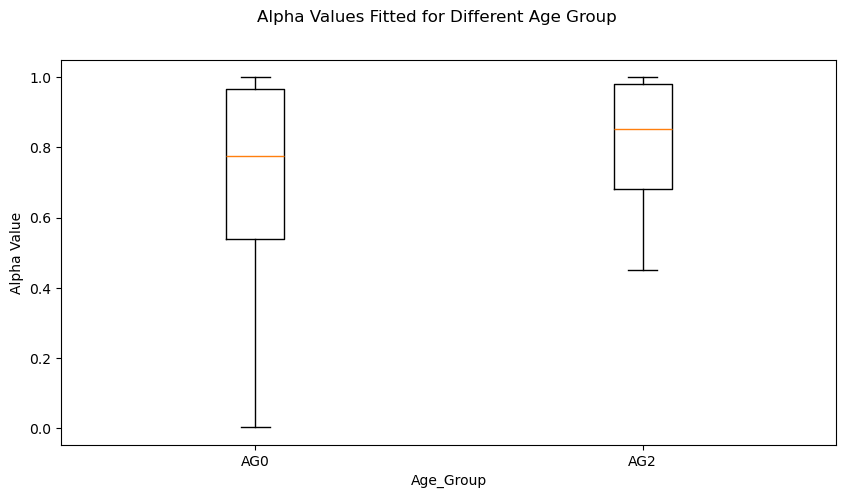

In [164]:
#Visualizing the parameter value generated through this negloglik minimization
fig1 = plt.figure(figsize =(10,5))

AG0_alpha = [p[0] for p in AG0_params]
AG2_alpha = [p[0] for p in AG2_params]

fig1.suptitle('Alpha Values Fitted for Different Age Group')
plt.xlabel('Age_Group')
plt.ylabel('Alpha Value')
plt.boxplot([AG0_alpha, AG2_alpha], labels=['AG0', 'AG2'])

plt.show()

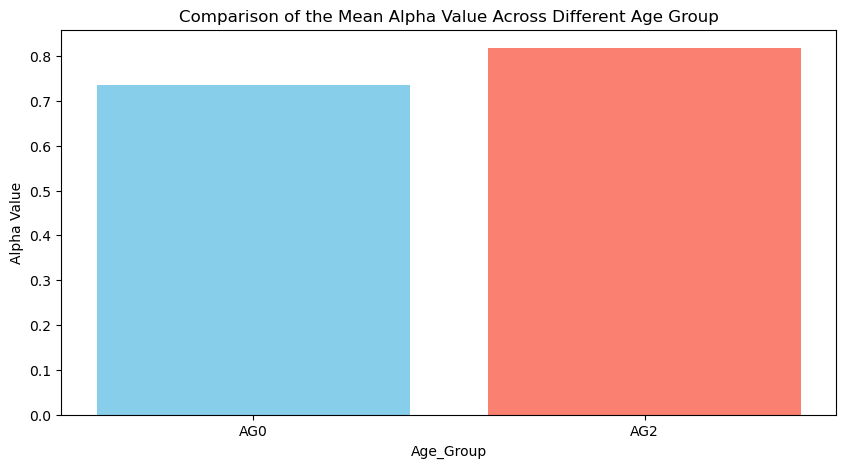

In [ ]:
fig2 = plt.figure(figsize =(10,5))

#labels=['AG0','AG2'],

plt.bar(['AG0', 'AG2'],[mean_alpha0, mean_alpha2],color=['skyblue','salmon'])
plt.xlabel('Age_Group')
plt.ylabel('Alpha Value')
plt.title('Comparison of the Mean Alpha Value Across Different Age Group')
plt.show()

/var/folders/nn/5m7xhsdj28g92vn5kdvwz0680000gn/T/ipykernel_38053/1151601865.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AG0_theta, AG2_theta], labels=['AG0', 'AG2'])


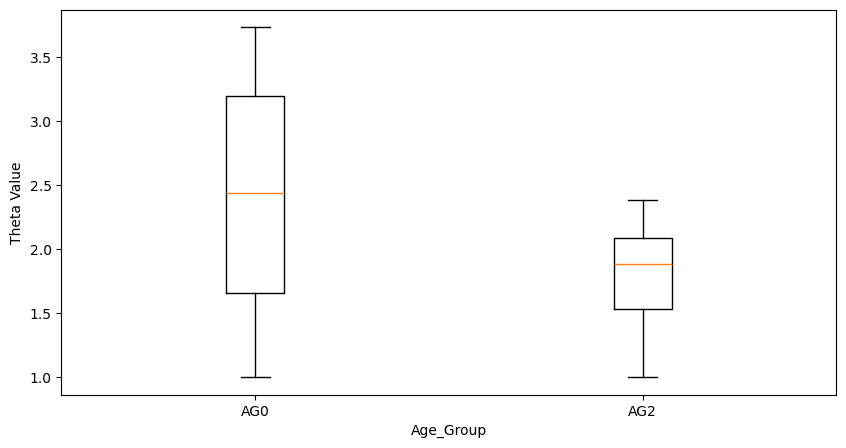

In [182]:
#Visualizing the parameter value generated through this negloglik minimization
fig = plt.figure(figsize =(10,5))

#There is an outlier with stochasticity of 50
#Removing outlier
AG0_params_kill_Outliers = AG0_params
del AG0_params_kill_Outliers[-3]


AG0_theta = [p[1] for p in AG0_params_kill_Outliers]
AG2_theta = [p[1] for p in AG2_params]

fig1.suptitle('Theta Values Fitted for Different Age Group')
plt.xlabel('Age_Group')
plt.ylabel('Theta Value')
plt.boxplot([AG0_theta, AG2_theta], labels=['AG0', 'AG2'])

plt.show()

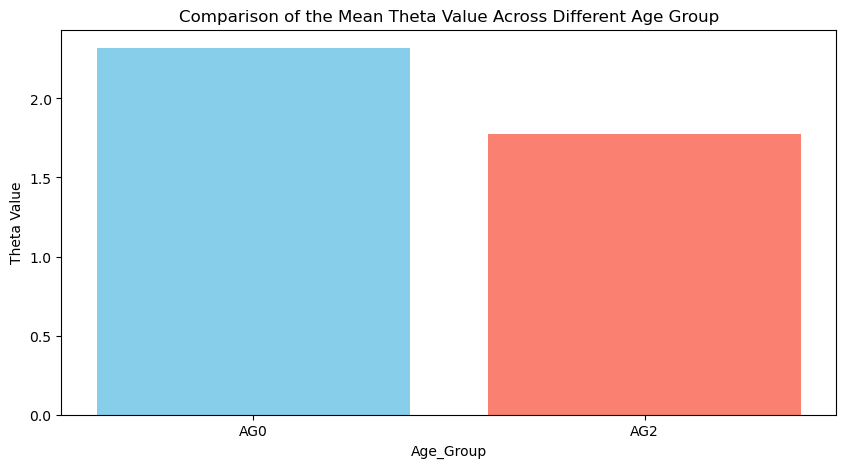

In [181]:
fig = plt.figure(figsize =(10,5))

#There is an outlier with stochasticity of 50
#Removing outlier
AG0_params_kill_Outliers = AG0_params
del AG0_params_kill_Outliers[-3]

mean_theta0 = np.mean([params[1] for params in AG0_params_kill_Outliers])
mean_theta2 = np.mean([params[1] for params in AG2_params])


plt.bar(['AG0', 'AG2'],[mean_theta0, mean_theta2],color=['skyblue','salmon'])
plt.xlabel('Age_Group')
plt.ylabel('Theta Value')
plt.title('Comparison of the Mean Theta Value Across Different Age Group')
plt.show()

## Obtaining the Learning-rate and choice stochasticity parameter for all sessions

In [ ]:
#Fitting parameter for different sessions

#Initialize lists to store the parameters
#Session_ID_params = []
#AG0_params= []
#AG2_params= []
Session_ID_params = {'Session_ID':[],'alpha':[],'theta':[],'Age_Groups':[]}

for session in data_df['Session_ID'].unique():

    print(session)

    result_session_dict = extracting_decision_reward_by_Session_ID(Session_ID=session)



    param_fits = Gradient_Descent(negloglik_RescorlaWagner,
                    result_session_dict['Decision'],
                    result_session_dict['Reward']
                )

    Session_ID_params['Session_ID'].append(session)
    Session_ID_params['alpha'].append(param_fits[0])
    Session_ID_params['theta'].append(param_fits[1])
    #Session_ID_params['Age_Groups'].append()

    #Session_ID_params.append(param_fits)

    if data_df[data_df['Session_ID'] == session]['Age_Groups'].iloc[0] == 0:
        Session_ID_params['Age_Groups'].append(0)
        
    else:
        Session_ID_params['Age_Groups'].append(1)
        


print(Session_ID_params)
#print(AG0_alpha)
#print(AG2_alpha)

#mean_alpha0 = np.mean([params[0] for params in AG0_params])
#mean_alpha2 = np.mean([params[0] for params in AG2_params])
#print(f'Mean alpha AG0 = {mean_alpha0};Mean alpha AG2 = {mean_alpha2}')

YC1N_Session5
YC1N_Session6
YC1N_Session7
YC1N_Session8
YC1N_Session9
YC1N_Session10
YC1L_Session5
YC1L_Session6
YC1L_Session7
YC1L_Session8
YC1L_Session9
YC1R_Session5
YC1R_Session6
YC1R_Session7
YC1R_Session8
YC1R_Session9
YC1R_Session10
YC1B_Session5
YC1B_Session6
YC1B_Session7
YC1B_Session8
YC1B_Session9
YC1B_Session10
YC2N_Session5
YC2N_Session6
YC2N_Session7
YC2N_Session8
YC2N_Session9
YC2N_Session10
YC2L_Session5
YC2L_Session6
YC2L_Session7
YC2L_Session8
YC2L_Session9
YC2L_Session10
YC2R_Session5
YC2R_Session6
YC2R_Session7
YC2R_Session8
YC2R_Session9
YC2R_Session10
YC2B_Session5
YC2B_Session6
YC2B_Session7
YC2B_Session8
YC2B_Session9
YC2B_Session10
YC3N_Session5
YC3N_Session6
YC3N_Session7
YC3N_Session8
YC3N_Session9
YC3N_Session10
YC3L_Session5
YC3L_Session6
YC3L_Session7
YC3L_Session8
YC3L_Session9
YC3L_Session10
YC3BLL_Session5
YC3BLL_Session6
YC3BLL_Session7
YC3BLL_Session8
YC3BLL_Session9
YC3BLL_Session10
YC3B_Session5
YC3B_Session6
YC3B_Session7
YC3B_Session8
YC3B_Session

In [ ]:
#Calculating the mean alpha
para_by_Session_ID = pd.DataFrame(Session_ID_params)

total_mean_alpha0 = para_by_Session_ID.loc[para_by_Session_ID['Age_Groups']==0,'alpha'].mean(skipna=True)
total_mean_alpha2 = para_by_Session_ID.loc[para_by_Session_ID['Age_Groups']==1,'alpha'].mean(skipna=True)
print(f'Mean alpha AG0 = {total_mean_alpha0};Mean alpha AG2 = {total_mean_alpha2}')

Mean alpha AG0 = 0.7037874626620714;Mean alpha AG2 = 0.7119130000967214


### Comparison of Learning-rate (alpha) across different AG

/var/folders/nn/5m7xhsdj28g92vn5kdvwz0680000gn/T/ipykernel_38053/2961788085.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_AG0_alpha, all_AG2_alpha], labels=['AG0', 'AG2'])


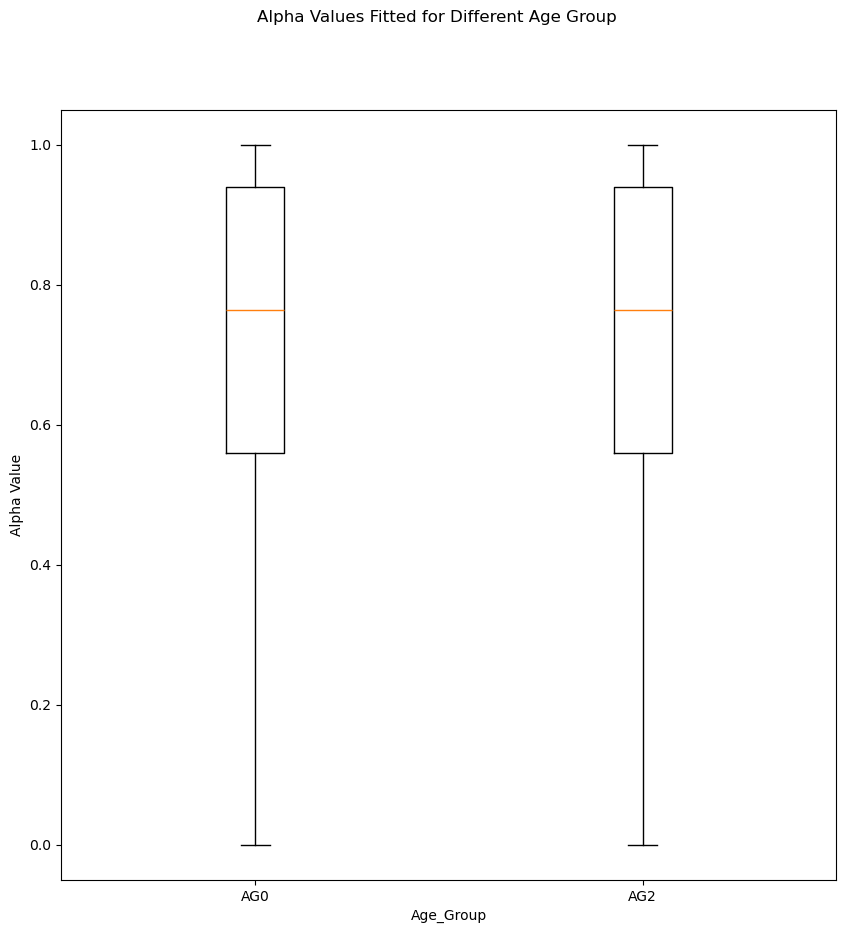

In [198]:
#Visualizing the parameter value generated through this negloglik minimization
fig1 = plt.figure(figsize =(10,10))

all_AG0_alpha = np.array(para_by_Session_ID.loc[para_by_Session_ID['Age_Groups']==0,'alpha'])
all_AG2_alpha = np.array(para_by_Session_ID.loc[para_by_Session_ID['Age_Groups']==0,'alpha'])

fig1.suptitle('Alpha Values Fitted for Different Age Group')
plt.xlabel('Age_Group')
plt.ylabel('Alpha Value')
plt.boxplot([all_AG0_alpha, all_AG2_alpha], labels=['AG0', 'AG2'])

plt.show()

## Reference ##
Rhoads, S. A. & Gan, L. (2022). Computational models of human social behavior and neuroscience - An open educational course and Jupyter Book to advance computational training. Journal of Open Source Education, 5(47), 146. https://doi.org/10.21105/jose.00146